# Data exploration

In [2]:
from typing import Tuple
import pandas as pd
import sys
sys.path.append("../") # go to parent dir

def load_datasets(storage_folder) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    return [pd.read_pickle(storage_folder / f'{phase}_beatmaps.pkl') for phase in
            ['train', 'val', 'test']]

In [3]:
from IPython.display import display, Markdown, Latex

def dataset_stats(df: pd.DataFrame):
    # 1/2 of snippets are overlapping
    group_over = ['name', 'difficulty', 'snippet', 'time', ]
    for end_index in range(1, len(group_over) + 1):
        print(f"{df.groupby(group_over[:end_index]).ngroups:9} unique {' × '.join(group_over[:end_index])}")
    
    print(f"{df.groupby(['name']).apply(lambda x: x.index.to_frame()['time'].max()).sum() / 3600:9.2f} "
          'hours of unique audio')
    print(f"{df.groupby(['name', 'difficulty']).apply(lambda x: x.index.to_frame()['time'].max()).sum() / 3600:9.2f} "
          'hours of unique gameplay')
    print(f"{len(df['word'].unique()):9} unique actions")

def whole_dataset_stats(train, val, test):
    display(Markdown('### Train'))
    dataset_stats(train)
    display(Markdown('### Validation'))
    dataset_stats(val)
    display(Markdown('### Test'))
    dataset_stats(test)
    display(Markdown('### Unique actions overlap'))
    print(f'{len(set(val.word.unique()) - set(train.word.unique())):9} unique actions in validation compared to train')
    print(f'{len(set(test.word.unique()) - set(train.word.unique()) - set(val.word.unique())):9} unique actions in test compared to train and validation')

In [4]:
from pathlib import Path

In [5]:
display(Markdown('## Our dataset'))
storage_folder = Path('../../data/old_datasets')
whole_dataset_stats(*load_datasets(storage_folder))

display(Markdown('## OxAI dataset'))
storage_folder = Path('../../data/new_datasets')
whole_dataset_stats(*load_datasets(storage_folder))

## Our dataset

### Train

      705 unique name
     1615 unique name × difficulty
    33883 unique name × difficulty × snippet
  1694150 unique name × difficulty × snippet × time
    38.07 hours of unique audio
    86.68 hours of unique gameplay
     2449 unique actions


### Validation

       86 unique name
      182 unique name × difficulty
     3779 unique name × difficulty × snippet
   188950 unique name × difficulty × snippet × time
     4.49 hours of unique audio
     9.22 hours of unique gameplay
      924 unique actions


### Test

       78 unique name
      179 unique name × difficulty
     4039 unique name × difficulty × snippet
   201950 unique name × difficulty × snippet × time
     4.23 hours of unique audio
     9.36 hours of unique gameplay
      946 unique actions


### Unique actions overlap

       96 unique actions in validation compared to train
       99 unique actions in test compared to train and validation


## OxAI dataset

### Train

      613 unique name
     1499 unique name × difficulty
    36141 unique name × difficulty × snippet
  1807050 unique name × difficulty × snippet × time
    32.48 hours of unique audio
    77.61 hours of unique gameplay
     2489 unique actions


### Validation

       80 unique name
      197 unique name × difficulty
     4927 unique name × difficulty × snippet
   246350 unique name × difficulty × snippet × time
     4.28 hours of unique audio
    10.40 hours of unique gameplay
     1060 unique actions


### Test

       72 unique name
      152 unique name × difficulty
     3916 unique name × difficulty × snippet
   195800 unique name × difficulty × snippet × time
     3.93 hours of unique audio
     8.19 hours of unique gameplay
      981 unique actions


### Unique actions overlap

      105 unique actions in validation compared to train
       79 unique actions in test compared to train and validation


## Number of beat elements per action

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})

def plot_action_distro(df: pd.DataFrame):
    ax = (train.word.str.len() // 5 + 1).value_counts().sort_index().plot.bar(logy=True, figsize=(16, 8))
    ax.set_title('Number of beat elements per action')

    by_difficulty = train.groupby('difficulty').apply(lambda df: (df.word.str.len() // 5 + 1).value_counts().sort_index().to_frame().T)

    by_difficulty.index = by_difficulty.index.droplevel(1)

    ax = by_difficulty.reindex(['Easy', 'Normal', 'Hard', 'Expert', 'ExpertPlus',], fill_value=0.0).plot.bar(logy=True, figsize=(16, 8))
    ax.set_title('Number of beat elements per action per distribution')
    ax.set_ylabel('# of actions')

## Our dataset

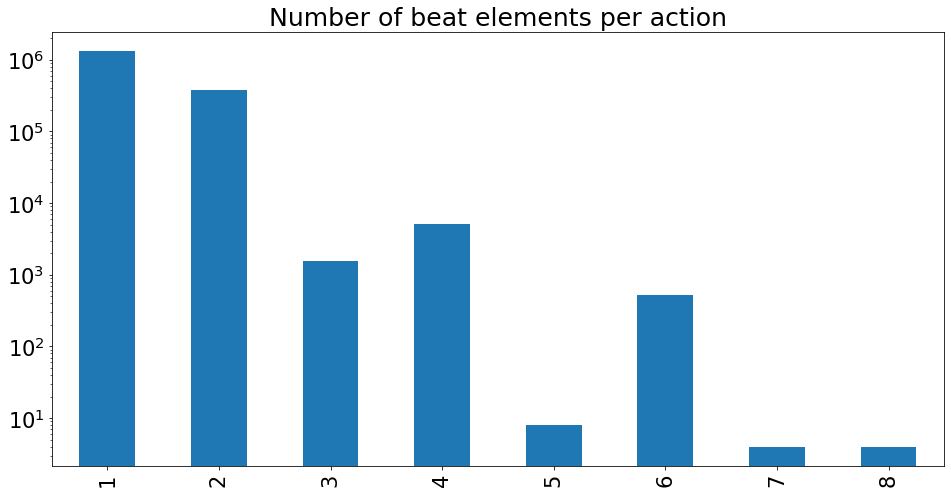

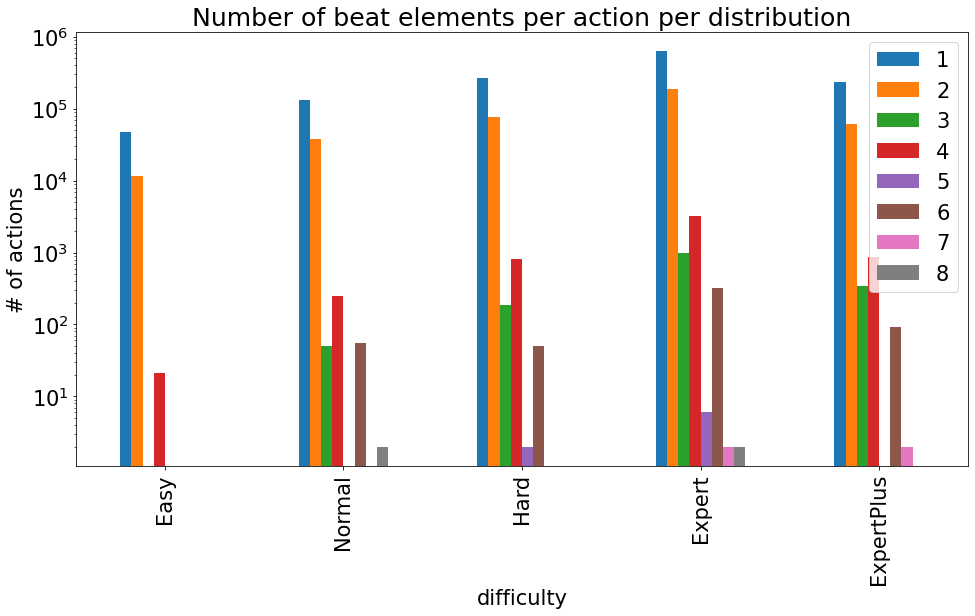

In [5]:
display(Markdown('## Our dataset'))
storage_folder = Path('../../data/old_datasets')
train, val, test = load_datasets(storage_folder)
plot_action_distro(train)

## OxAI dataset

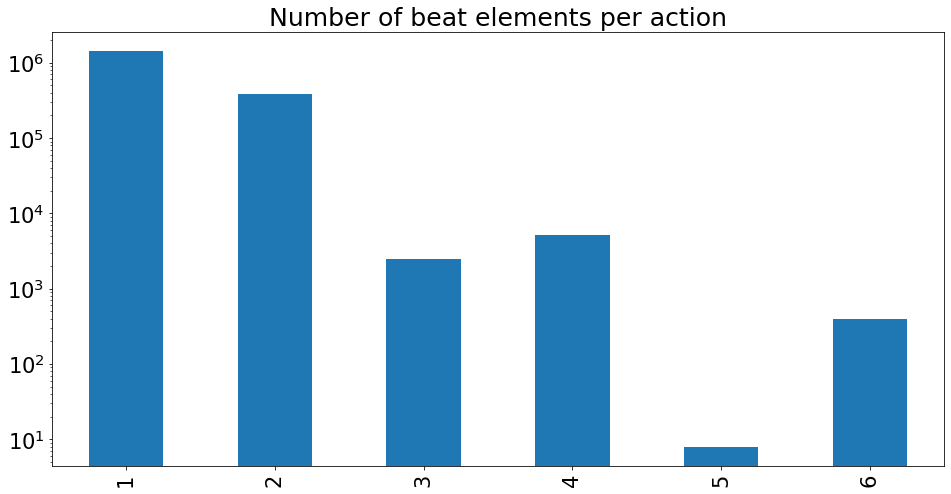

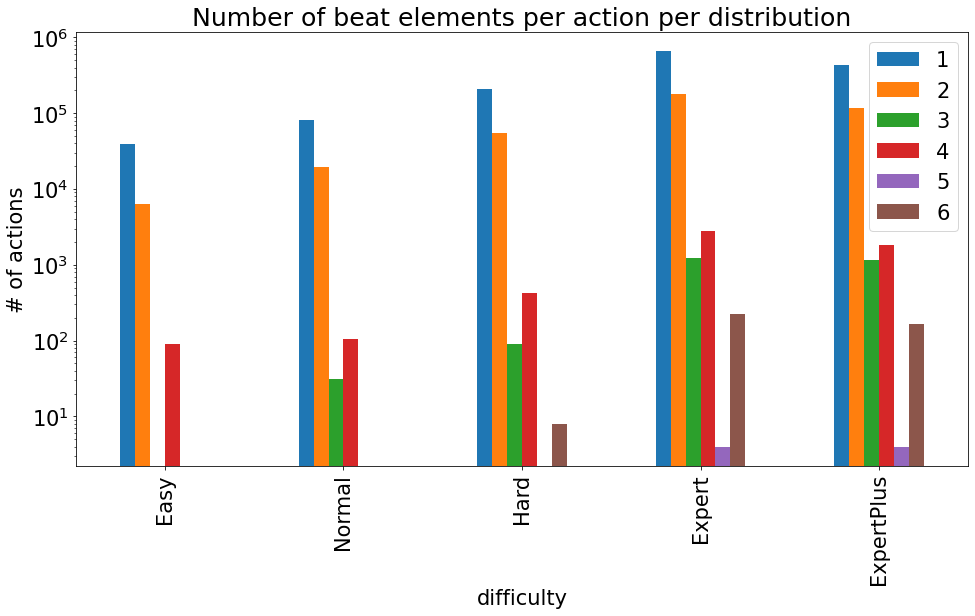

In [6]:
display(Markdown('## OxAI dataset'))
storage_folder = Path('../../data/new_datasets')
train, val, test = load_datasets(storage_folder)
plot_action_distro(train)

## Song length

In [7]:
def create_sentence(x):
    x.name = 'word'
    x = x.reset_index('time')
    x = x.drop_duplicates('time')
    return x.word.to_list()

def plot_sentence_lengths(df):
    lengths = df.droplevel(2).word.groupby(['name', 'difficulty']).apply(create_sentence).str.len()
    ax = lengths.plot.hist(figsize=(16, 8))
    ax.set_xlabel('Sentence length [# words]')
    display(lengths.describe().to_frame())

## Our dataset

,word
count,1615.000000
mean,512.653251
std,250.657588
min,57.000000
25%,329.500000
50%,469.000000
75%,645.000000
max,1701.000000


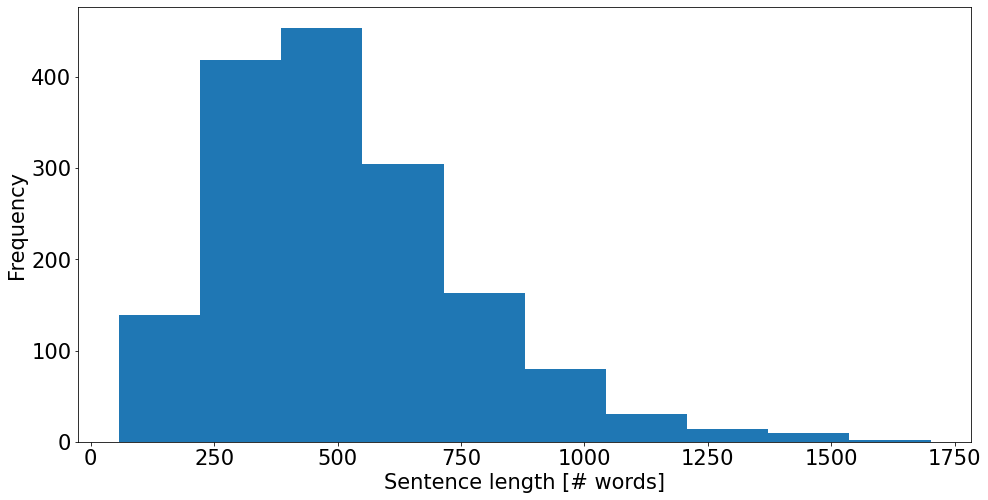

In [218]:
display(Markdown('## Our dataset'))
storage_folder = Path('../../data/old_datasets')
train, val, test = load_datasets(storage_folder)
plot_sentence_lengths(train)

## OxAI dataset

,word
count,1499.000000
mean,590.402268
std,315.588323
min,52.000000
25%,360.000000
50%,548.000000
75%,758.000000
max,3013.000000


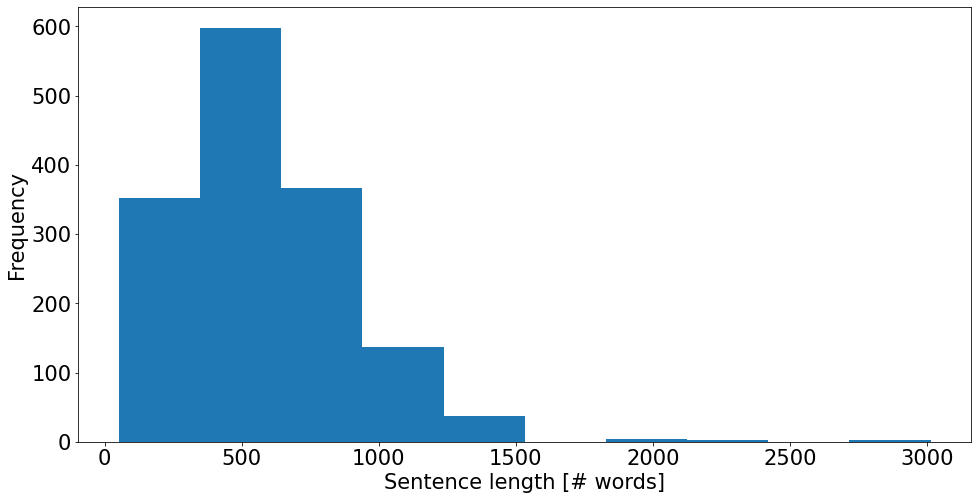

In [9]:
display(Markdown('## OxAI dataset'))
storage_folder = Path('../../data/new_datasets')
train, val, test = load_datasets(storage_folder)
plot_sentence_lengths(train)

## WordVec velocity

In [10]:
import numpy as np

def get_vec_df(df):
    nodup = df.droplevel(2)
    nodup = nodup.loc[~nodup.index.duplicated()]

    top = 900000 #9000
    return pd.DataFrame(np.array(nodup.word_vec.values.tolist())[:top], index=nodup.index[:top])

train_vec = get_vec_df(train)
val_vec = get_vec_df(val)

In [11]:
from scipy.spatial import distance

def cosine_dist(a, b):
    return 1 - np.sum(a * b, axis=-1)  / (np.linalg.norm(a, axis=-1) * np.linalg.norm(b, axis=-1))

difficulty
Easy          AxesSubplot(0.125,0.125;0.775x0.755)
Expert        AxesSubplot(0.125,0.125;0.775x0.755)
ExpertPlus    AxesSubplot(0.125,0.125;0.775x0.755)
Hard          AxesSubplot(0.125,0.125;0.775x0.755)
Normal        AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

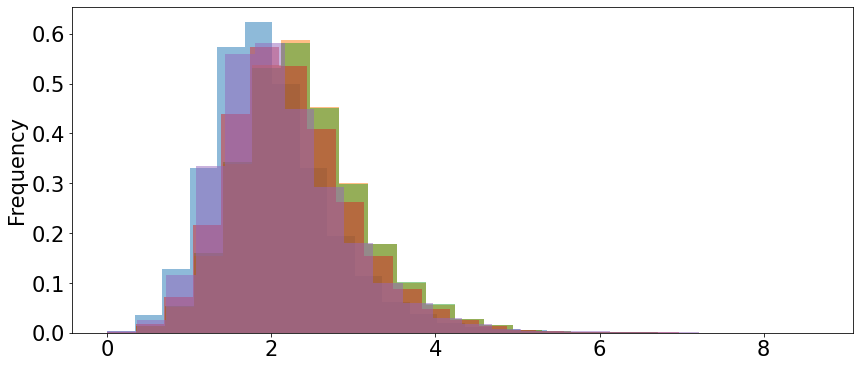

In [12]:
from matplotlib import pyplot as plt 

def compute_velocity(df, window=7):
    means = df.iloc[::].rolling(window, win_type='boxcar').mean(std=7, tau=7, sym=False)

    velocity  = cosine_dist(means.values, means.shift(window).values)
    diff = means - means.shift(window)
    velocity = ((diff.dropna()**2).sum(axis=1))**(1/2)
    return pd.Series(velocity).dropna()

ax = train_vec.groupby(['name', 'difficulty']).apply(compute_velocity).groupby('difficulty').plot.hist(bins=24, figsize=(14, 6), density=True, alpha=0.5)
# ax.set_xlim(0, 5)
ax

In [13]:
train_vel = train_vec.groupby(['name', 'difficulty']).apply(compute_velocity).reset_index(1)
val_vel = val_vec.groupby(['name', 'difficulty']).apply(compute_velocity).reset_index(1)
val_vel.difficulty.unique()

array(['Expert', 'Hard', 'Normal', 'ExpertPlus', 'Easy'], dtype=object)

### Kolmogorov-Smirnov statistic on 2 samples
> This tests whether 2 samples are drawn from the same distribution. Note that, like in the case of the one-sample KS test, the distribution is assumed to be continuous.

> If the KS statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

[[Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html)]

[[0.03198574 0.05753873 0.18704871 0.17659763]
 [0.07809979 0.03535754 0.1028425  0.09289579]
 [0.16534574 0.12543581 0.01644438 0.00835458]
 [0.1618863  0.12270927 0.01745884 0.00903631]]
[[2.55746789e-005 2.19167385e-037 0.00000000e+000 0.00000000e+000]
 [6.52278907e-032 2.85277027e-017 0.00000000e+000 1.32836589e-212]
 [2.01897589e-146 1.17601800e-232 9.24840912e-012 1.82322470e-002]
 [2.46982976e-139 3.73008591e-218 1.71802069e-012 1.01965128e-002]]


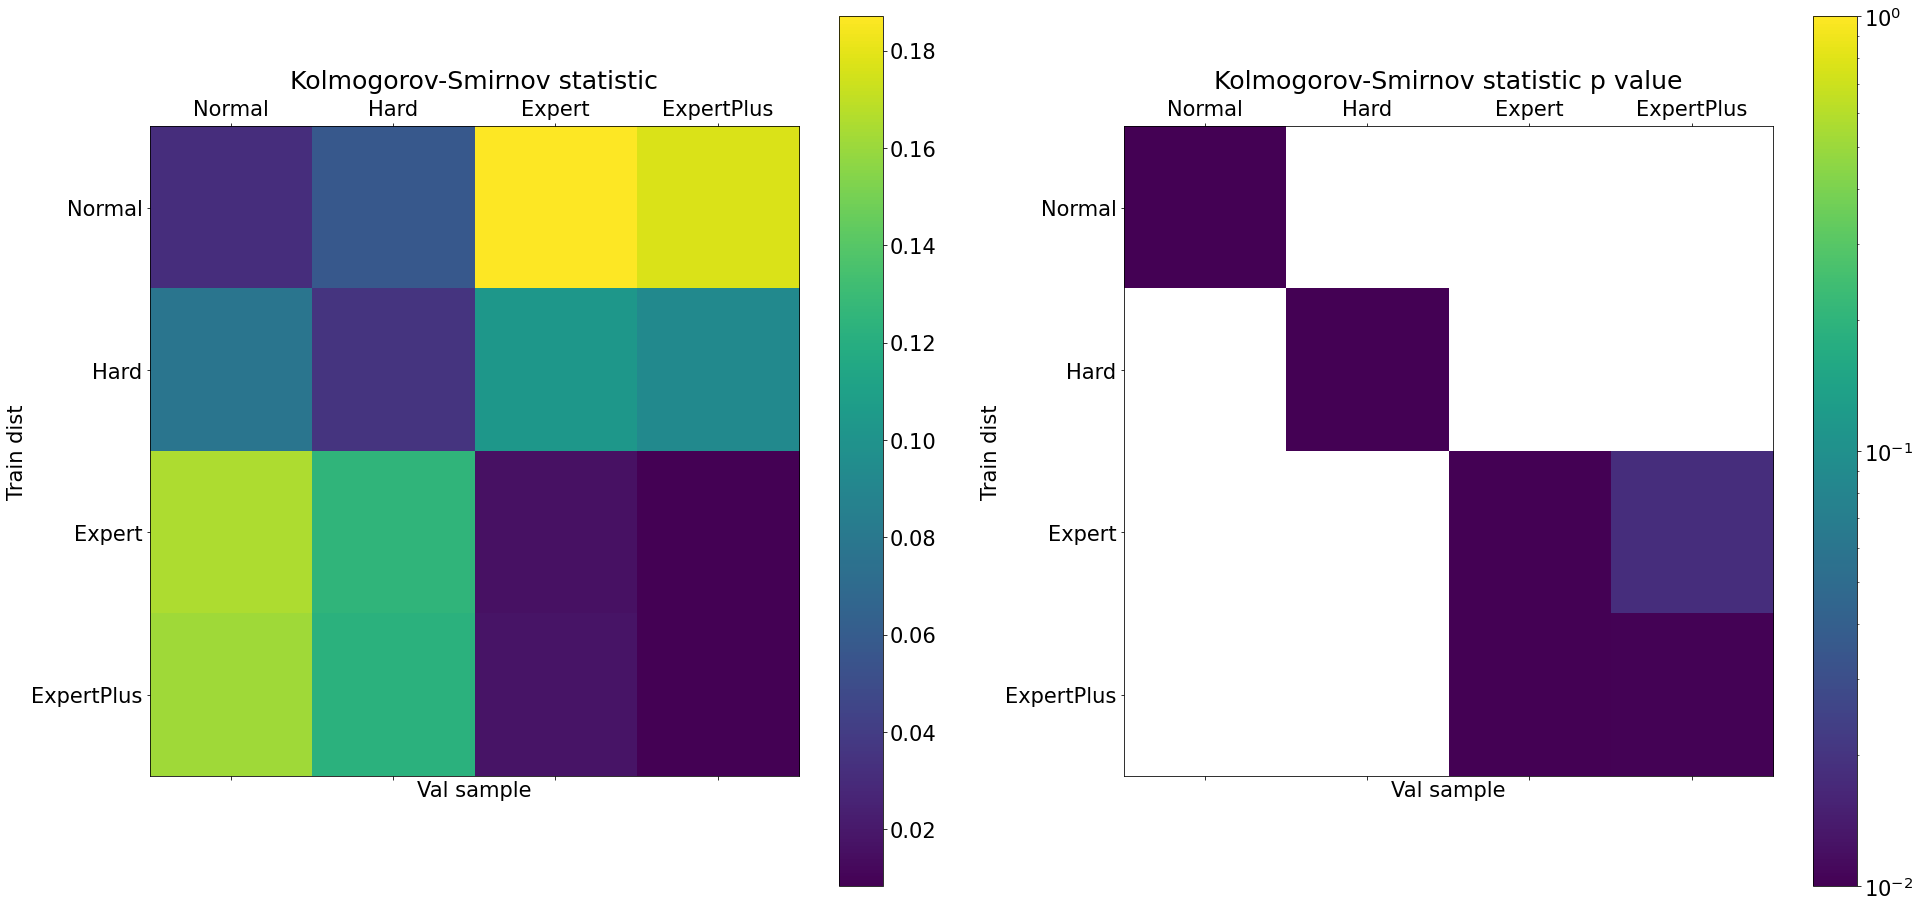

In [14]:
from matplotlib.colors import LogNorm
from scipy.stats import ks_2samp

difficulties = ['Normal', 'Hard', 'Expert', 'ExpertPlus', ]
use_songs = 5

stat = np.zeros((len(difficulties), ) * 2)
pval = np.zeros((len(difficulties), ) * 2)

for i, dif0 in enumerate(difficulties):
    for j, dif1 in enumerate(difficulties):
        if dif0 != dif1 or True:
            stat[i, j], pval[i, j] = ks_2samp(train_vel.loc[train_vel.difficulty == dif0][0][:],
                                            val_vel.loc[val_vel.difficulty == dif1][0][:500 * use_songs])

print(stat)
fig = plt.figure(figsize=(32, 16))
ax = fig.add_subplot(121)
cax = ax.matshow(stat)
plt.title('Kolmogorov-Smirnov statistic')
fig.colorbar(cax)
ax.set_xticklabels([''] + difficulties)
ax.set_yticklabels([''] + difficulties)
plt.ylabel('Train dist')
plt.xlabel('Val sample')
# plt.show()

print(pval)
ax = fig.add_subplot(122)
cax = ax.matshow(pval, norm=LogNorm(vmin=0.01, vmax=1))
# cax = ax.matshow(pval, )   # for non log color
plt.title('Kolmogorov-Smirnov statistic p value')
fig.colorbar(cax)
ax.set_xticklabels([''] + difficulties)
ax.set_yticklabels([''] + difficulties)
plt.ylabel('Train dist')
plt.xlabel('Val sample')
plt.show()

In [109]:
import numpy as np
from scipy.stats import norm
from scipy.special import kl_div
from matplotlib import pyplot as plt
import tensorflow as tf
# import seaborn as sns
# sns.set()

In [110]:
def kl_divergence(p, q, epsilon=1e-7):
    return np.sum(np.where(p != 0, p * np.log(p / (q + epsilon)), 0))

In [111]:
train_vel

difficulty         0
name name difficulty time                        
250f 250f Expert     6.499       Expert  1.864312
                     8.250       Expert  1.880612
                     9.000       Expert  2.058487
                     9.251       Expert  2.042945
                     9.499       Expert  2.401655
...                                 ...       ...
b50  b50  Hard       215.225       Hard  0.674069
                     215.808       Hard  1.730550
                     216.425       Hard  1.310578
                     217.334       Hard  2.200781
                     218.447       Hard  1.682667

[865526 rows x 2 columns]

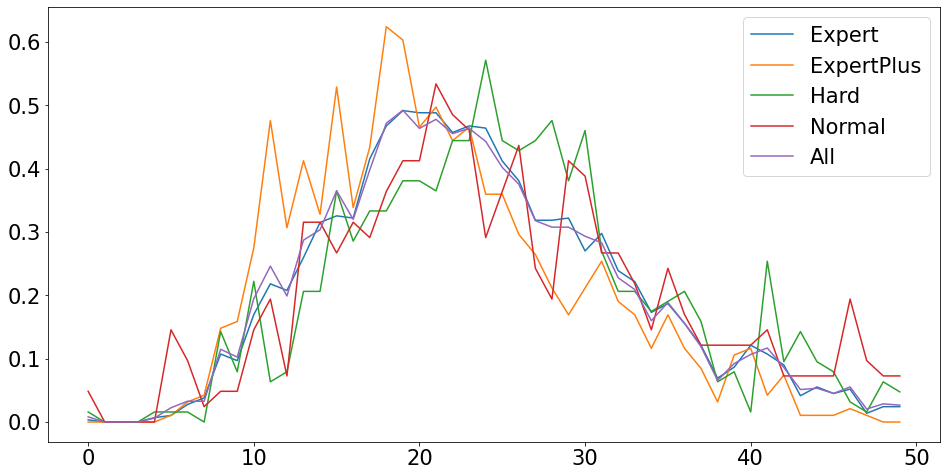

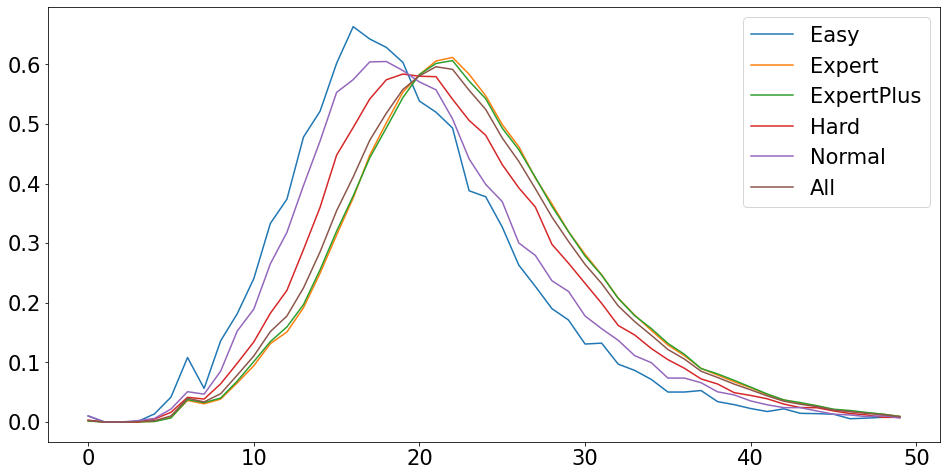

In [121]:
def get_bins(ser):
    hist = np.histogram(ser,
                        density=True,
                        bins=50,
                        range=(0, 5),
                       )
    return hist[0]

use_beatmaps = 50
train_bins = train_vel[0].groupby('difficulty').apply(get_bins)
val_bins = val_vel[0][:500 * use_beatmaps].groupby('difficulty').apply(get_bins)

train_bins = train_bins.append(pd.Series([get_bins(train_vel[0])], index=['All']))
val_bins = val_bins.append(pd.Series([get_bins(val_vel[0][:500 * use_beatmaps])], index=['All']))
ax = pd.DataFrame(val_bins.values.tolist(), index=val_bins.index).T.plot(figsize=(16, 8))
ax = pd.DataFrame(train_bins.values.tolist(), index=train_bins.index).T.plot(figsize=(16, 8))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


[[2.03269635 2.7029296  0.85388341 0.81674038 0.81087507]
 [1.4536283  1.79726571 0.42341538 0.78716769 0.44036696]
 [1.18104399 1.31570557 0.36063235 1.23535465 0.42805386]
 [1.15017793 1.32497492 0.33351834 1.19553879 0.39827073]
 [1.20019935 1.42392259 0.32015009 1.04001531 0.36963533]]


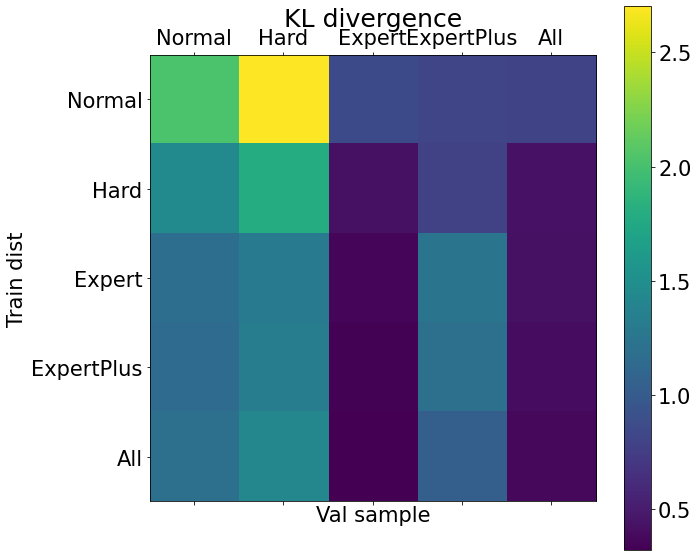

In [122]:
from matplotlib.colors import LogNorm
difficulties = ['Normal', 'Hard', 'Expert', 'ExpertPlus', 'All']

kld = np.zeros((len(difficulties), ) * 2)

for i, dif0 in enumerate(difficulties):
    for j, dif1 in enumerate(difficulties):
        try:
            kld[i, j] = kl_divergence(train_bins[dif0], val_bins[dif1])
        except KeyError:
            pass

print(kld)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
cax = ax.matshow(kld)
plt.title('KL divergence')
fig.colorbar(cax)
ax.set_xticklabels([''] + difficulties)
ax.set_yticklabels([''] + difficulties)
plt.xlabel('Val sample')
plt.ylabel('Train dist')
plt.show()

## Compute action velocity for multiple windows

In [21]:
use_beatmaps = 100000 // 500
snippet = val_vec.iloc[:500 * use_beatmaps].groupby(['name', 'difficulty'])

res = {}
for window, train_v in cached_train_v.items():
    snippet_v = snippet.apply(lambda df: compute_velocity(df, window))
    stat = ks_2samp(train_v, snippet_v)[0]
    print(f'{window:4}\t{stat:3.2f}\t| means: '
          f'{train_v.mean():2.2f} {snippet_v.mean():2.2f}')
    res[window] = stat
    
pd.Series(res).describe()

   1	0.01	| means: 6.10 6.14
   2	0.04	| means: 4.18 4.28
   3	0.03	| means: 3.37 3.42
   4	0.03	| means: 2.87 2.92
   5	0.03	| means: 2.68 2.73
   6	0.03	| means: 2.48 2.53
   7	0.02	| means: 2.33 2.36
   8	0.02	| means: 2.20 2.22
   9	0.02	| means: 2.11 2.13
  10	0.02	| means: 2.03 2.05
  11	0.02	| means: 1.96 1.97
  12	0.02	| means: 1.89 1.90
  13	0.01	| means: 1.84 1.84
  14	0.01	| means: 1.80 1.79
  15	0.01	| means: 1.75 1.74
  16	0.01	| means: 1.71 1.70
  17	0.01	| means: 1.67 1.66
  18	0.01	| means: 1.64 1.62
  19	0.01	| means: 1.61 1.59
  20	0.01	| means: 1.58 1.56
  21	0.01	| means: 1.56 1.53
  22	0.01	| means: 1.53 1.51
  23	0.01	| means: 1.51 1.48
  24	0.02	| means: 1.49 1.46
  25	0.02	| means: 1.47 1.44
  26	0.02	| means: 1.45 1.42
  27	0.02	| means: 1.43 1.40
  28	0.02	| means: 1.42 1.39
  29	0.02	| means: 1.40 1.37
  30	0.03	| means: 1.39 1.36
  31	0.03	| means: 1.37 1.34


count    31.000000
mean      0.018900
std       0.007982
min       0.008682
25%       0.011209
50%       0.019644
75%       0.024150
max       0.040808
dtype: float64

In [81]:
from multiprocessing import Pool
from itertools import starmap

def compute_complete_velocity(ser, window):
    return window, ser.groupby(['name', 'difficulty']).apply(lambda ser_: compute_velocity(ser_, window))

def multi_cached_v(df):
    pool = Pool()
#     cached_train_v = dict(pool.starmap(compute_complete_velocity, [(df, window) 
#                                                                    for window in range(1, 32)]))
    cached_train_v = dict(starmap(compute_complete_velocity, [(df, window) 
                                                                   for window in range(1, 32)]))
    pool.close()
    pool.join()
    return cached_train_v


%time multi_cached_train_v = multi_cached_v(train_vec.iloc[:100000])

CPU times: user 2min 44s, sys: 3.76 s, total: 2min 48s
Wall time: 2min 27s


In [39]:
train_vec.iloc[:100000].head()

0         1         2         3         4    \
name difficulty time                                                      
250f Expert     3.251 -0.266113 -0.449707 -0.362793 -0.254639  0.042419   
                3.499  0.220825 -0.323486  0.155273  0.071594  0.168457   
                3.750  0.426514 -0.512695 -0.006756  0.090088  0.092712   
                4.001  0.265625 -0.117798  0.336670  0.079407  0.175415   
                4.249 -0.041138 -0.600586 -0.325195 -0.202515  0.159668   

                            5         6         7         8         9    ...  \
name difficulty time                                                     ...   
250f Expert     3.251  0.327637 -0.307129  0.291992 -0.256104 -0.386230  ...   
                3.499  0.022079  0.180176 -0.244019  0.076660 -0.583984  ...   
                3.750  0.260254  0.171997 -0.134766 -0.174561 -0.401367  ...   
                4.001 -0.155518 -0.025421 -0.255127 -0.771484 -0.799316  ...   
                4.249  0.403076  0.008995  0.390381 -0.645020 -0.792969  ...   

                            246       247       248       249       250  \
name difficulty time                                                      
250f Expert     3.251 -0.122192 -0.346436 -0.024017 -0.121582 -0.542480   
                3.499 -0.495850 -1.007812 -0.817383 -0.194336 -0.996094   
                3.750 -0.122803  0.426025 -0.015869 -0.433838  0.175903   
                4.001 -0.256104 -0.486816 -0.265869 -0.318115 -0.673828   
                4.249 -0.273193 -0.408936 -0.887207 -0.031052 -1.969727   

                            251       252       253       254       255  
name difficulty time                                                     
250f Expert     3.251 -0.135132 -0.132324  0.216675  0.211304  0.003870  
                3.499  0.484375 -0.381348 -0.824707 -0.628418  0.429199  
                3.750 -0.400391 -0.143433  0.247070 -0.071594  0.210083  
                4.001  0.227905 -0.238281 -0.541992 -0.572754  0.195923  
                4.249  0.621582 -0.655273 -0.427734 -0.253906  0.415283  

[5 rows x 256 columns]

In [79]:
import gc
gc.collect()
del algo_cached_train_v, per_cached_train_v, multi_cached_train_v

gc.collect()

NameError: name 'algo_cached_train_v' is not defined

In [80]:
def get_window_v(df, i):
    df /= i
    return i, (((df - df.shift(i)).dropna()**2).sum(axis=1))**(1/2)

def algo_cached_v(df):
    windows_size = 32
    sum_dict = {1: df}
    shifted = df
    for i in range(2, windows_size):
        shifted = shifted.shift(1)
        sum_dict[i] = sum_dict[i-1] + shifted

    params = ((sum_dict[window], window) for window in range(1, windows_size))
    pool = Pool()
    sum_dict = dict(pool.starmap(get_window_v, params))
    pool.close()
    pool.join()
        
#   pure single core
#     for i in range(1, windows):
#         sum_dict[i] /= i
#         sum_dict[i] = (((sum_dict[i] - sum_dict[i].shift(i)).dropna()**2).sum(axis=1))**(1/2)
    return sum_dict


%time algo_cached_train_v = algo_cached_v(train_vec.iloc[:100000])

CPU times: user 11.7 s, sys: 7.13 s, total: 18.8 s
Wall time: 39.2 s


1         2         3
name difficulty time                                
250f Expert     3.499   6.398438       NaN       NaN
                3.750   7.023438       NaN       NaN
                4.001   6.375000  4.164062       NaN
                4.249   6.308594  3.998047       NaN
                4.500   8.359375  4.562500  3.597656
...                          ...       ...       ...
3539 ExpertPlus 25.317  8.750000  0.000000  2.642578
                25.461  6.457031  3.494141  2.152344
                25.609  4.035156  4.617188  4.429688
                25.752  4.496094  3.673828  4.714844
                25.896  4.445312  2.822266  3.695312

[99999 rows x 3 columns]

In [64]:
%time per_cached_train_v = train_vec.iloc[:100000].groupby(['name', 'difficulty']).apply(algo_cached_v)

CPU times: user 13.4 s, sys: 16.7 ms, total: 13.4 s
Wall time: 13.4 s


name  difficulty
250f  Expert        {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
2d9a  Expert        {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
      ExpertPlus    {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
3038  Easy          {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
      Expert        {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
                                          ...                        
34fe  Normal        {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
3519  Expert        {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
      Normal        {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
3539  Expert        {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
      ExpertPlus    {1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,...
Length: 167, dtype: object

In [30]:
train_vec.iloc[:100000].groupby(['name', 'difficulty']).apply(lambda ser_: compute_velocity(ser_, 3))

name  difficulty  name  difficulty  time  
250f  Expert      250f  Expert      22.500    0.999408
                                    22.751    0.908603
                                    22.999    0.930006
                                    23.250    0.991410
                                    23.501    1.004286
                                                ...   
3539  ExpertPlus  3539  ExpertPlus  25.317    1.315136
                                    25.461    1.122963
                                    25.609    0.875245
                                    25.752    0.747014
                                    25.896    0.629000
Length: 89813, dtype: float64

{1: name  difficulty  name  difficulty  time  
 250f  Expert      250f  Expert      3.499     6.397644
                                     3.750     7.024971
                                     4.001     6.374097
                                     4.249     6.309538
                                     4.500     8.360320
                                                 ...   
 3539  ExpertPlus  3539  ExpertPlus  25.317    8.751420
                                     25.461    6.456174
                                     25.609    4.037505
                                     25.752    4.496775
                                     25.896    4.444268
 Length: 99833, dtype: float64,
 2: name  difficulty  name  difficulty  time  
 250f  Expert      250f  Expert      4.001     4.164709
                                     4.249     3.999108
                                     4.500     4.563166
                                     4.751     5.717417
                                  

In [28]:
algo_cached_train_v

{1:                              0         1         2         3         4    \
 name difficulty time                                                       
 250f Expert     3.251  -0.266113 -0.449707 -0.362793 -0.254639  0.042419   
                 3.499   0.220825 -0.323486  0.155273  0.071594  0.168457   
                 3.750   0.426514 -0.512695 -0.006756  0.090088  0.092712   
                 4.001   0.265625 -0.117798  0.336670  0.079407  0.175415   
                 4.249  -0.041138 -0.600586 -0.325195 -0.202515  0.159668   
 ...                          ...       ...       ...       ...       ...   
 3539 ExpertPlus 25.317  0.277832 -0.240601  0.422363  0.033081  0.092834   
                 25.461  0.265625 -0.117798  0.336670  0.079407  0.175415   
                 25.609  0.161255 -0.132202  0.235474  0.292480  0.215088   
                 25.752  0.283203 -0.195801  0.241821  0.170166 -0.050598   
                 25.896  0.323486 -0.023438  0.348877  0.166016 -0.290527

In [155]:


for window, train_v in cached_train_v.items():
    snippet_v = snippet.apply(lambda df: compute_velocity(df, window))
    stat = kl_divergence(get_bins(train_v), get_bins(snippet_v))
    print(f'{window:4}\t{stat:3.2f}\t|means: {train_v.mean()} {snippet_v.mean()}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


   2	0.49	|means: 4.216285887696275 4.102688147331439
   3	0.16	|means: 3.379721592515502 3.4276538078147967
   4	0.23	|means: 2.892121582821202 3.007898844524915
   5	0.27	|means: 2.6802256302758445 2.8070075795753198
   6	0.30	|means: 2.4834529264454637 2.621796376500898
   7	0.32	|means: 2.325874368125198 2.482436512363166
   8	0.40	|means: 2.193081196309724 2.3654645272815076
   9	0.45	|means: 2.109388555593811 2.2831558500371
  10	0.51	|means: 2.026207303662766 2.2130661966606904
  11	0.63	|means: 1.94825594593367 2.143638112143433
  12	0.69	|means: 1.8767062971103525 2.0863470219307088
  13	0.73	|means: 1.8257779776724983 2.0427616563763102
  14	0.83	|means: 1.7754126262887364 2.0063367548251594
  15	0.96	|means: 1.7267733320820495 1.972825248379185
  16	1.25	|means: 1.6818095028810414 1.9454501300551448
  17	1.28	|means: 1.6471806692471014 1.9231129343017324
  18	1.46	|means: 1.6131290331202348 1.9014941512752523
  19	1.50	|means: 1.5820132518273406 1.881109237496009
  20	1.79	|

In [130]:
import gc
gc.collect()

28

## LaTeX DataFrame output

In [183]:
storage_folder = Path('../../data/old_datasets')
train, val, test = load_datasets(storage_folder)
val.index.to_frame().name.unique()[:100]

array(['AMENOHOAKARI', 'Adventure of a Lifetime',
       'All Time Low (BOXINLION Remix)', 'Alone Slushii Remix', 'Always',
       'Armed And Ready', 'BABYMETAL-Starlight', 'BRAVE JEWEL (TV size)',
       'Bangarang', 'Beat it', 'Becoming', 'Black Rover (TV Size)',
       'Bonfire', 'Bottle of Jack - Mikey Wax',
       'Boulevard of Broken Dreams', 'Bring it Back - Tisoki',
       'Careless Whisper', 'Closer', 'Conqueror', 'Courage',
       'Crack Traxxxx', 'Crawling', 'Crossing Field',
       'Darkside - Alan Walker', 'EC1-Rio', 'Fire Hive (Rickput)',
       'Flat Zone 2', 'Good Morning USA', 'Goodbye to A World',
       'Heaven Rd 2', "Hideki Naganuma - AIN'T NOTHIN' LIKE A FUNKY BEAT",
       'High Hopes', 'Hitorigoto - ClariS', 'Hype feat. Such',
       'Hyper Drive', 'Hysteria', 'I Knew You Were In Trouble',
       'I Took A Pill In Ibiza (SeeB Remix)', 'I nyaned for Hours',
       'Ignite (SAO)', 'John Powell - Test Drive', 'Jump Up, Super Star!',
       'LAST GAME (TV-Size)', 'L

In [116]:
storage_folder = Path('../../data/new_datasets')
train, val, test = load_datasets(storage_folder)
print(val.head().to_latex())
print(val.columns)
val.iloc[500:600].head()

\begin{tabular}{llllrrrrrrlrrrllrrrrrrrlr}
\toprule
     &        &   &       &  l\_lineLayer &  l\_lineIndex &  l\_cutDirection &  r\_lineLayer &  r\_lineIndex &  r\_cutDirection &       word &   prev &   next &      part &                                               mfcc &                                           word\_vec &  word\_id &  prev\_l\_lineLayer &  prev\_l\_lineIndex &  prev\_l\_cutDirection &  prev\_r\_lineLayer &  prev\_r\_lineIndex &  prev\_r\_cutDirection &                                      prev\_word\_vec &  prev\_word\_id \\
name & difficulty & snippet & time &              &              &                 &              &              &                 &            &        &        &           &                                                    &                                                    &          &                   &                   &                      &                   &                   &                      &                          

l_lineLayer  l_lineIndex  l_cutDirection  \
name difficulty snippet time                                               
30ef Expert     250     90.918            0            2               1   
                        91.249            1            0               2   
                        91.420            0            1               1   
                        91.579            0            3               7   
                        91.751            0            0               6   

                                r_lineLayer  r_lineIndex  r_cutDirection  \
name difficulty snippet time                                               
30ef Expert     250     90.918            0            3               1   
                        91.249            1            0               2   
                        91.420            0            2               1   
                        91.579            0            3               7   
                        91.751            0            0               6   

                                     word   prev   next      part  ...  \
name difficulty snippet time                                       ...   
30ef Expert     250     90.918  L021_R031  0.330  0.331  0.275581  ...   
                        91.249       L102  0.331  0.171  0.276584  ...   
                        91.420  L011_R021  0.171  0.159  0.277103  ...   
                        91.579       R037  0.159  0.172  0.277584  ...   
                        91.751       L006  0.172  0.158  0.278106  ...   

                                                                         word_vec  \
name difficulty snippet time                                                        
30ef Expert     250     90.918  [-0.2642, -0.1865, -0.2078, -0.2866, 0.09827, ...   
                        91.249  [0.2184, 0.0528, 0.561, -0.0498, -0.0955, 0.40...   
                        91.420  [-0.02002, 0.11383, 0.1425, -0.02528, 0.178, -...   
                        91.579  [-0.3286, -0.305, 0.003819, -0.01487, 0.3926, ...   
                        91.751  [-0.3596, -0.1683, -0.335, -0.2322, 0.07153, 0...   

                               word_id  prev_l_lineLayer  prev_l_lineIndex  \
name difficulty snippet time                                                 
30ef Expert     250     90.918      88                 1                 3   
                        91.249       4                 0                 2   
                        91.420      25                 1                 0   
                        91.579      63                 0                 1   
                        91.751      79                 0                 3   

                                prev_l_cutDirection  prev_r_lineLayer  \
name difficulty snippet time                                            
30ef Expert     250     90.918                    3                 1   
                        91.249                    1                 0   
                        91.420                    2                 1   
                        91.579                    1                 0   
                        91.751                    7                 0   

                                prev_r_lineIndex  prev_r_cutDirection  \
name difficulty snippet time                                            
30ef Expert     250     90.918                 3                    3   
                        91.249                 3                    1   
                        91.420                 0                    2   
                        91.579                 2                    1   
                        91.751                 3                    7   

                                                                    prev_word_vec  \
name difficulty snippet time                                                        
30ef Expert     250     90.918  [0.5366, -0.287, 0.8335, -0.02771, 0.5464, 0.1...   
                        9

## Data changes exploration

In [118]:
storage_folder = Path('../../data/new_datasets_config_test') # 26 + 26
train, val, test = load_datasets(storage_folder)

In [130]:
val.index.to_frame().difficulty.unique()

array(['Expert', 'Hard', 'Normal', 'ExpertPlus', 'Easy'], dtype=object)

In [143]:
len(set(train.word.unique()) - set(train.xs('ExpertPlus', level='difficulty').word.unique()))

297

In [151]:
len(set(train.xs('ExpertPlus', level='difficulty').word.unique()) & set(train.word.unique()))

2192

In [150]:
len(train.word.unique())- 297 - 2192

2489

In [89]:
class ArbitraryDataclass():
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)
            
class DataDict():
    def __init__(self):
        self.__dict = {}
        
    def __setitem__(self, key, val):
        self.__dict[key] = ArbitraryDataclass(**val)
        
    def __getitem__(self, key):
        return self.__dict[key]

models = ['m1', 'm2', ]
data = DataDict()

def data_prep(data, models):
    for m in models:
        a = m + '-a'
        b = m + '-b'
        data[m] = locals()

def visualize(data, models):
    for m in models:
        l = data[m]
        print(l.a, l.b, )

data_prep(data, models)
visualize(data, models)

data['m1'].train

m1-a m1-b
m2-a m2-b


AttributeError: 'ArbitraryDataclass' object has no attribute 'train'

In [84]:
q = 'asd'

In [88]:
class A():
    def __setattr__(self, name, value):
        print(name, value)
        super(A, self).__setattr__(name, value)
        
    def __getattr__(self, name):
        print(name)
        super(A, self).__getattr__(name)
        
a = A()
a.val = '123'
a.val = 12
a.val

val 123
val 12


12